# Validating the use of Random Forest for WW Cross-section Measurement ( 45% WW, n_WW*2 = DY, n_WW = TT)

In [1]:
run prep_ana.py

loading data frame named df.
finished loading data frame
unc_mc_process and scales are dictionaries
scale_data = (5.27/19.7)


/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
%matplotlib inline

In [66]:
def pre_cuts( df ):
    ht_cut = df.HT < 70
    qT_cut = df.qT > 20
    mll_cut = (df.mll < 76 ) | (df.mll > 106)
    
    diff = ( df.lep_Type > 0 ) 
    same = ( df.lep_Type < 0)
    
    df_s = df[ same & ht_cut & mll_cut ]
    df_d = df[ diff & ht_cut ]
    return pd.concat( [df_s, df_d])

In [67]:
#load root files
df_WW = rp.read_root("data/WW_tot_complete.root", "trees_vec")
df_DY = rp.read_root("data/DY_ll_complete.root", "trees_vec")
df_TT = rp.read_root("data/TT_ll_complete.root", "trees_vec")

df = pd.concat( [df_WW, df_TT, df_DY] )
df = pre_cuts( df)
df = df.reset_index()

In [68]:
for process in df.process.unique():
    print process, df[ df.process == process].shape

WW (89423, 59)
TT (185467, 59)
DY (222528, 59)


In [133]:
train_WW = df[df.process=="WW"].sample( frac= 0.45 )
train_DY = df[df.process=="DY"].sample( frac= 0.45)#n=train_WW.shape[0] )
train_TT = df[df.process=="TT"].sample( frac= 0.45)#n=train_WW.shape[0] )
train = pd.concat( [train_WW, train_DY, train_TT] )

test = df.drop( train.index )
print train.shape, test.shape

(223838, 59) (273580, 59)


In [134]:
features = ['numb_jets', 'METProj', 'METProj_trk_sin', 'METProj_sin', 'qT', 'met_over_sET', 'dPhiLLMET', 'dPhiLLJet', 'dPhiLL', 'dPhiMETJet', 'lep_Type', 'mllMET', 'recoil' ] +\
            ['jetPt1', 'jet1_csv']
#features = [ 'numb_jets', 'METProj_sin', 'met_over_sET','METProj_trk_sin', 'qT', 'mllMET', 'recoil', 'jetPt1', 'dPhiLLJet', 'dPhiLLMET', 'dPhiMETJet', 'lep_Type' ]

# RF

In [135]:
#labels
labels = np.empty( train.shape[0] )
weights = np.empty( train.shape[0] )

labels[(train.process == "WW").as_matrix()] = 1
labels[(train.process == "DY").as_matrix()] = 2
labels[(train.process == "TT").as_matrix()] = 2

weights[(train.process == "WW").as_matrix()] = 1
weights[(train.process == "DY").as_matrix()] = 1
weights[(train.process == "TT").as_matrix()] = 1

In [136]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, min_samples_split=10, max_depth=15, max_features='sqrt')
clf = clf.fit( np.float32(train[features].values) , np.float32(labels), sample_weight=weights)

In [137]:
print clf.score(np.float32(train[features].values), np.float32(labels), weights)

0.920728383921


In [138]:
#labels and weights
df_labels = np.empty( df.shape[0] )
df_weights = np.empty( df.shape[0])

df_labels[(df.process == "WW").as_matrix()] = 1
df_labels[(df.process == "DY").as_matrix()] = 2
df_labels[(df.process == "TT").as_matrix()] = 2

df_weights[(df.process == "WW").as_matrix()] = 1.
df_weights[(df.process == "DY").as_matrix()] = 1
df_weights[(df.process == "TT").as_matrix()] = 1

print clf.score(np.float32(df[features].values), np.float32(df_labels), df_weights)

0.908372837332


In [139]:
pred = clf.predict_proba(np.float32(test[features].values))

test["pred_WW"] = pred[:,0]
test["pred_DY"] = pred[:,1]
test["pred_TT"] = pred[:,1]

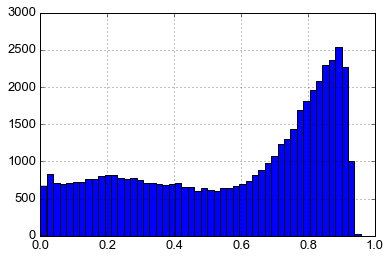

In [140]:
test[ (test.process == "WW") ].pred_WW.hist( bins= 50 )

In [143]:
cut = 0.694
feature_cuts =  (test.pred_WW > cut) & (test.numbExtraLep == 0) #& (test_df.qT > 0) & ()
feature_cuts_diff =( test.lep_Type > 0 ) & feature_cuts & (test.qT > 20)
feature_cuts_same = (test.lep_Type < 0) & feature_cuts #& (test.METProj_trk_sin > 30)
print "\tdiff", "\tsame"
for process in scales.keys():
    if process in test.process.unique():
        print process, test[ (test.process == process) & feature_cuts_diff].shape[0] * scales[process] * float(df[df.process == process].shape[0])/float(test[test.process == process].shape[0]),\
    test[ (test.process == process) & feature_cuts_same].shape[0] * scales[process] * float(df[df.process == process].shape[0])/float(test[test.process == process].shape[0])

	diff 	same
WW 3069.87020144 1171.78956758
DY 444.400319453 1005.09231129
TT 193.799202702 67.1909070528


	diff 	same
WW 3822.56038396 1396.70063673
DY 926.491382568 879.341693887
TT 296.422420831 129.310621147

In [14]:
df_DY.sample( frac=.05).shape

(164657, 58)

In [15]:
train[train.process == "DY"].shape

(102240, 59)

In [113]:
s_ww = float(df[df.process == "WW"].shape[0])/float(test[test.process == "WW"].shape[0])
s_dy = float(df[df.process == "DY"].shape[0])/float(test[test.process == "DY"].shape[0])
s_tt = float(df[df.process == "TT"].shape[0])/float(test[test.process == "TT"].shape[0])

(<matplotlib.axes._subplots.AxesSubplot at 0x167c133d0>,
 [<Container object of 50 artists>,
  <Container object of 50 artists>,
  <Container object of 50 artists>],
 ['DY', 'TT', 'WW'])

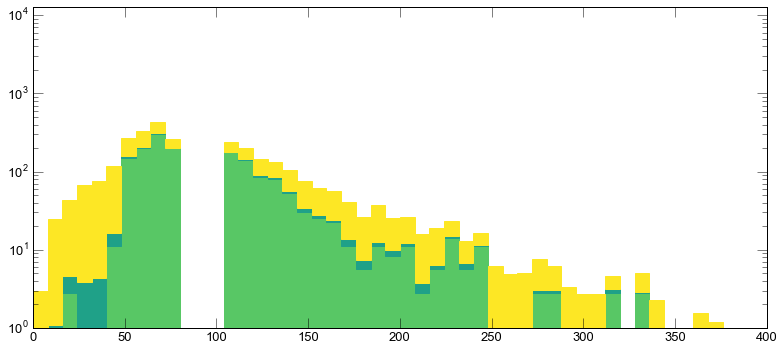

In [132]:
feature = 'mll'
range= (0,400)#(-.5,9.5)
cut = 0.805#.954
bins=50
#test.METProj_trk_sin

cuts = (test.pred_WW > cut) & (test.lep_Type < 0)

bin_mc = bin_df( test[cuts], feature, range=range, scales={"WW":scales["WW"] * s_ww, "DY":scales["DY"] * s_dy, "TT":scales["TT"] * s_tt ,\
                                                          'WZ_2l2q': 1, 'WZ_3ln': 1, 'ZZ':1, "WZ":1}, bins=bins)
plot_hist(bin_mc, processes=["DY","TT","WW"])#y_range=True, logy=False)

In [18]:
print test[ cuts & (test.process == "DY") & (test.METProj_trk_sin < 25)].shape[0] * s_dy * scales["DY"]
print test[ cuts & (test.process == "WW") & (test.METProj_trk_sin < 25)].shape[0] * s_ww * scales["WW"]

0.0
0.0


In [126]:
for e, f in enumerate(clf.feature_importances_):
    print features[e], f

numb_jets 0.0303822711639
METProj 0.0575080141109
METProj_trk_sin 0.0551667657272
METProj_sin 0.0654336110956
qT 0.109833595986
met_over_sET 0.0311794057858
dPhiLLMET 0.0833446582837
dPhiLLJet 0.0437550901164
dPhiLL 0.045263224147
dPhiMETJet 0.0322994126429
lep_Type 0.152042358539
mllMET 0.0692972986982
recoil 0.0700483466886
jetPt1 0.0509478495649
jet1_csv 0.10349809745
